### Forecast Revisions with TimeDB

This notebook demonstrates how to work with overlapping forecast revisions in TimeDB.

#### What you'll learn:
1. **Creating overlapping forecasts** - Multiple forecasts for the same series with different known_time
2. **Reading all forecast revisions** - Querying all versions of forecasts with a single query
3. **Visualizing forecast revisions** - Plotting overlapping forecasts to see how they evolve

**Key Concepts:**
- `known_time`: When the forecast was made (batch_start_time)
- `valid_time`: The time period the forecast predicts
- Overlapping forecasts: Multiple forecasts made at different times predicting the same future periods
- Series identification: Each series has a unique combination of name, unit, and labels

## Part 1: Setup and Create Database Schema


In [1]:
from timedb import TimeDataClient
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

td = TimeDataClient()
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


In [2]:
forecast_series_id = td.create_series(
    name='forecast',
    unit='MW',
    labels={'type': 'power_forecast', 'model': 'sinus_with_error'},
    description='Forecasted power values with overlapping revisions'
)

actual_series_id = td.create_series(
    name='actual',
    unit='MW',
    labels={'type': 'power_actual'},
    description='Actual power values (ground truth)'
)


## Part 2: Create 4 Forecasts with Shifting Valid Times

We'll create 4 forecasts in a loop, where each forecast's `valid_time` range starts at its `known_time`. The `batch_start_time` will default to the current time when the script runs. All forecasts:
- Use the same series_id (with name='forecast', unit='MW', labels={'type': 'power_forecast', 'model': 'sinus_with_error'})
- Have a 3-day horizon with hourly resolution (72 hours)
- Have `known_time` set 1 day apart
- Each forecast's `valid_time` starts at its `known_time`, so later forecasts are shifted forward in time


In [3]:
base_valid_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
forecast_horizon_hours = 72
num_forecasts = 4

for i in range(num_forecasts):
    # Generate mock forecasts
    known_time = base_valid_time + timedelta(days=i)
    valid_times = [known_time + timedelta(hours=j) for j in range(forecast_horizon_hours)]
    base_power = 100.0; amplitude = 30.0; period_hours = 24
    hours_from_start = np.arange(forecast_horizon_hours)
    sinus_base = base_power + amplitude * np.sin(2 * np.pi * hours_from_start / period_hours)
    np.random.seed(42 + i)  # Different seed for each forecast for reproducibility
    error_std = amplitude * 0.03  # Error std is 1% of sinus amplitude (small relative to pattern)
    error_steps = np.random.normal(0, error_std, forecast_horizon_hours)
    error_walk = np.cumsum(error_steps)
    forecast_values = sinus_base + error_walk
    forecast_values = np.round(forecast_values, 2).tolist()

    # Insert forecasts
    df_forecast = pd.DataFrame({
        "valid_time": valid_times,
        "forecast": forecast_values
    })
    result = td.series("forecast").where(
        type='power_forecast',
        model='sinus_with_error'
    ).insert_batch(
        df=df_forecast,
        known_time=known_time
    )

# Generate actual values
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(days=num_forecasts - 1) + timedelta(hours=forecast_horizon_hours)
actual_valid_times = []
current_time = start_valid
while current_time < end_valid:
    actual_valid_times.append(current_time)
    current_time += timedelta(hours=1)
# Insert actual values
base_power = 100.0; amplitude = 30.0; period_hours = 24
hours_from_start = np.arange(len(actual_valid_times))
actual_values = base_power + amplitude * np.sin(2 * np.pi * hours_from_start / period_hours)
actual_values = np.round(actual_values, 2).tolist()
df_actual = pd.DataFrame({
    "valid_time": actual_valid_times,
    "actual": actual_values
})
actual_known_time = actual_valid_times[-1]
result_actual = td.series("actual").where(type='power_actual').insert_batch(
    df=df_actual,
    known_time=actual_known_time
)


## Part 3: Read Latest Forecast Revisions

Now we'll read back the latest forecast revisions using `td.read()`.
This returns the latest forecast for each valid_time (most recent based on known_time) in a single query.


In [4]:
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(days=num_forecasts - 1) + timedelta(hours=forecast_horizon_hours)

# Read forecast series
df_forecast = td.series("forecast").where(
    type='power_forecast',
    model='sinus_with_error'
).read(
    start_valid=start_valid,
    end_valid=end_valid
)
# Read actual series
df_actual = td.series("actual").where(
    type='power_actual'
).read(
    start_valid=start_valid,
    end_valid=end_valid
)

# Combine into a single DataFrame
df_flat = pd.DataFrame({
    'forecast': df_forecast['forecast'],
    'actual': df_actual['actual']
}, index=df_forecast.index)


df_flat.head(10)

,forecast,actual
valid_time,,
2025-01-01 00:00:00+00:00,100.45,100.0
2025-01-01 01:00:00+00:00,108.09,107.76
2025-01-01 02:00:00+00:00,115.91,115.0
2025-01-01 03:00:00+00:00,123.49,121.21
2025-01-01 04:00:00+00:00,128.05,125.98
2025-01-01 05:00:00+00:00,130.83,128.98
2025-01-01 06:00:00+00:00,133.28,130.0
2025-01-01 07:00:00+00:00,132.94,128.98
2025-01-01 08:00:00+00:00,129.53,125.98


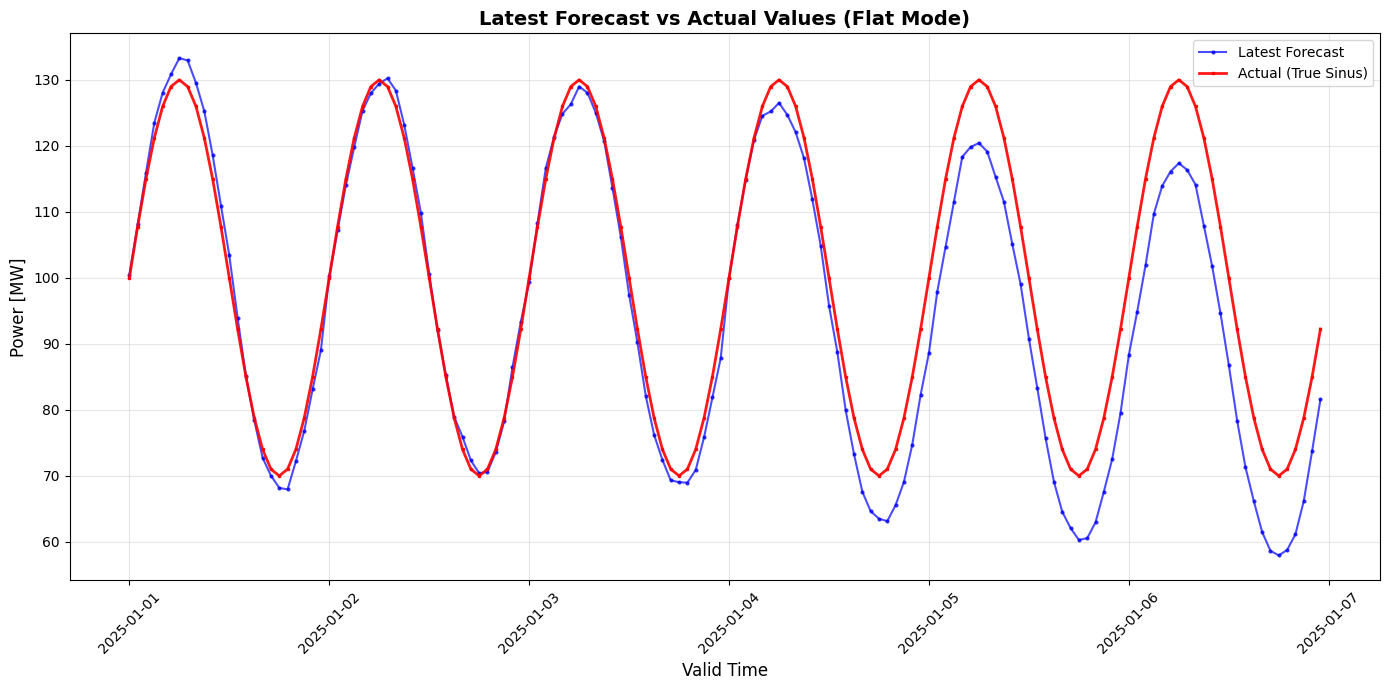

In [5]:
# Plot the latest forecast and actual values (flat mode)
plt.figure(figsize=(14, 7))

# Convert pint quantities to plain values for plotting
forecast_values = df_flat['forecast'].pint.magnitude if hasattr(df_flat['forecast'], 'pint') else df_flat['forecast'].values
actual_values = df_flat['actual'].pint.magnitude if hasattr(df_flat['actual'], 'pint') else df_flat['actual'].values

# Plot forecast and actual
plt.plot(df_flat.index, forecast_values, marker='o', markersize=2, linewidth=1.5, 
         label='Latest Forecast', alpha=0.7, color='blue')
plt.plot(df_flat.index, actual_values, marker='s', markersize=2, linewidth=2, 
         label='Actual (True Sinus)', alpha=0.9, color='red')

plt.xlabel('Valid Time', fontsize=12)
plt.ylabel('Power [MW]', fontsize=12)
plt.title('Latest Forecast vs Actual Values (Flat Mode)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Part 4: Read All Forecast Revisions (Overlapping Mode)

Now let's read all forecast revisions using `.read_values_overlapping()` on the series collection.
This returns all forecasts with both `known_time` and `valid_time`, showing how
forecasts evolve over time. This is useful for analyzing forecast revisions and backtesting.

In [6]:
# Calculate the overall valid_time range covering all forecasts
# First forecast starts at base_valid_time, last forecast ends at base_valid_time + (num_forecasts-1) days + forecast_horizon_hours
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(days=num_forecasts - 1) + timedelta(hours=forecast_horizon_hours)

# Use SeriesCollection.read_values_overlapping() to get all forecast revisions with (known_time, valid_time) multi-index
df_forecast_overlapping = td.series("forecast").where(
    type='power_forecast',
    model='sinus_with_error'
).read_values_overlapping(
    start_valid=start_valid,
    end_valid=end_valid,
    all_versions=True
)

# Read actual series (overlapping mode)
df_actual_overlapping = td.series("actual").where(
    type='power_actual'
).read_values_overlapping(
    start_valid=start_valid,
    end_valid=end_valid,
    all_versions=True
)

# Combine into a single DataFrame
df_overlapping = pd.concat([df_forecast_overlapping, df_actual_overlapping], axis=1)

print(f"✓ Read {len(df_overlapping)} data points")
print(f"\nDataFrame shape: {df_overlapping.shape}")
print(f"\nIndex levels: {df_overlapping.index.names}")
print(f"\nColumns: {list(df_overlapping.columns)}")
print(f"\nThis shows all forecast revisions, including all known_time values.")
print(f"\nFirst few rows:")
df_overlapping.head(10)

✓ Read 432 data points

DataFrame shape: (432, 2)

Index levels: ['known_time', 'valid_time']

Columns: ['forecast', 'actual']

This shows all forecast revisions, including all known_time values.

First few rows:


name                                                 forecast  actual
known_time                valid_time                                 
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00    100.45     nan
                          2025-01-01 01:00:00+00:00    108.09     nan
                          2025-01-01 02:00:00+00:00    115.91     nan
                          2025-01-01 03:00:00+00:00    123.49     nan
                          2025-01-01 04:00:00+00:00    128.05     nan
                          2025-01-01 05:00:00+00:00    130.83     nan
                          2025-01-01 06:00:00+00:00    133.28     nan
                          2025-01-01 07:00:00+00:00    132.94     nan
                          2025-01-01 08:00:00+00:00    129.53     nan
                          2025-01-01 09:00:00+00:00    125.25     nan

Plotting 4 forecast revisions...


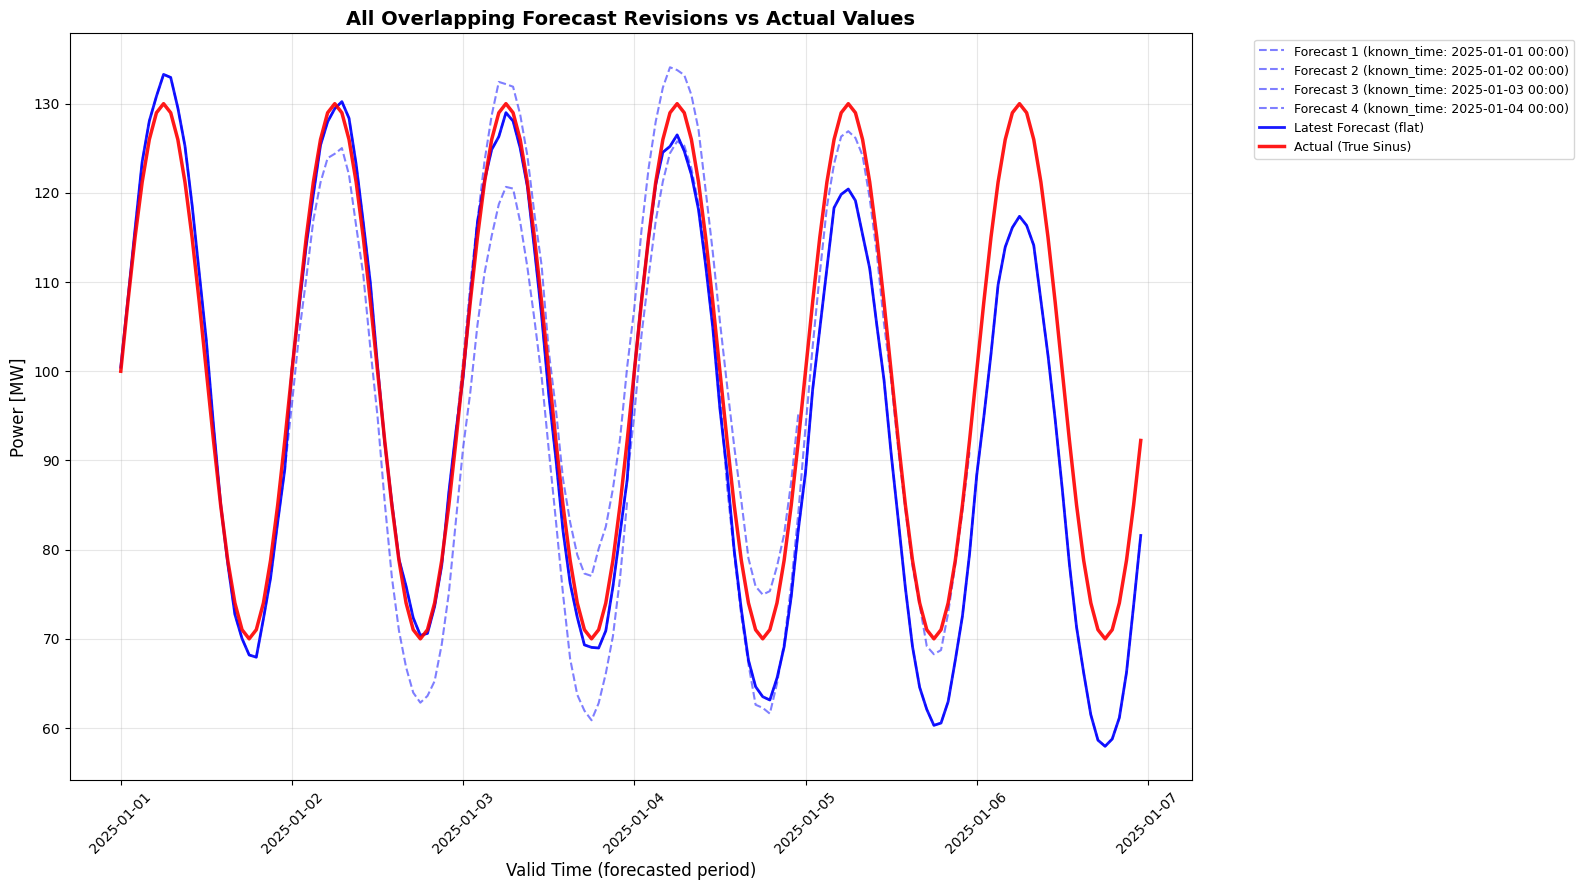

✓ All forecast revisions and actual values plotted successfully!


In [7]:
# Plot all overlapping forecasts and actual values
plt.figure(figsize=(16, 9))

# Separate forecast and actual data
df_forecast_only = df_overlapping[['forecast']].dropna()
df_actual_only = df_overlapping[['actual']].dropna()

# Get unique known_times from the forecast series only (exclude actual's known_time)
# Each known_time in the forecast series represents a different forecast revision
unique_known_times = df_forecast_only.index.get_level_values("known_time").unique()
unique_known_times = sorted(unique_known_times)

print(f"Plotting {len(unique_known_times)} forecast revisions...")

# Plot each forecast revision with dashed blue lines
for idx, known_time in enumerate(unique_known_times):
    # Get all values for this known_time
    forecast_data = df_forecast_only.xs(known_time, level="known_time")
    
    # Extract valid_time and values
    valid_times_plot = forecast_data.index
    values = forecast_data['forecast']
    
    # Convert pint quantities to plain values for plotting
    values_magnitude = values.pint.magnitude if hasattr(values, 'pint') else values.values
    
    # Plot this forecast revision with dashed blue line
    label = f"Forecast {idx+1} (known_time: {known_time.strftime('%Y-%m-%d %H:%M')})"
    plt.plot(valid_times_plot, values_magnitude, linewidth=1.5, linestyle='--', 
            label=label, color='blue', alpha=0.5)

# Plot the latest forecast from flat data with solid blue line
forecast_flat_values = df_flat['forecast'].pint.magnitude if hasattr(df_flat['forecast'], 'pint') else df_flat['forecast'].values
plt.plot(df_flat.index, forecast_flat_values, linewidth=2, linestyle='-', 
        label='Latest Forecast (flat)', color='blue', alpha=0.9, zorder=5)

# Plot actual values
# Actual values will have the same known_time (when they were inserted)
# Get unique valid_times and actual values (they should be the same across known_times)
actual_data = df_actual_only.reset_index()
# Group by valid_time and take the first value (they should all be the same)
actual_data = actual_data.groupby('valid_time')['actual'].first().sort_index()

# Convert pint quantities to plain values for plotting
actual_values = actual_data.pint.magnitude if hasattr(actual_data, 'pint') else actual_data.values

plt.plot(actual_data.index, actual_values, 
        linewidth=2.5, label='Actual (True Sinus)', alpha=0.9, color='red', zorder=10)

# Formatting
plt.xlabel('Valid Time (forecasted period)', fontsize=12)
plt.ylabel('Power [MW]', fontsize=12)
plt.title('All Overlapping Forecast Revisions vs Actual Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ All forecast revisions and actual values plotted successfully!")

In [8]:
# The DataFrame from read_values_overlapping already has the correct structure:
# - Index: (known_time, valid_time) - double index
# - Columns: series_key (in this case "power")
# No reshaping needed!

df_forecast_revisions = df_overlapping

print(f"✓ DataFrame with (known_time, valid_time) index and '{list(df_forecast_revisions.columns)[0]}' column")
print(f"\nDataFrame shape: {df_forecast_revisions.shape}")
print(f"\nIndex levels: {df_forecast_revisions.index.names}")
print(f"\nColumn: {list(df_forecast_revisions.columns)}")
print(f"\nFirst few rows:")
df_forecast_revisions.head(15)


✓ DataFrame with (known_time, valid_time) index and 'forecast' column

DataFrame shape: (432, 2)

Index levels: ['known_time', 'valid_time']

Column: ['forecast', 'actual']

First few rows:


name                                                 forecast  actual
known_time                valid_time                                 
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00    100.45     nan
                          2025-01-01 01:00:00+00:00    108.09     nan
                          2025-01-01 02:00:00+00:00    115.91     nan
                          2025-01-01 03:00:00+00:00    123.49     nan
                          2025-01-01 04:00:00+00:00    128.05     nan
                          2025-01-01 05:00:00+00:00    130.83     nan
                          2025-01-01 06:00:00+00:00    133.28     nan
                          2025-01-01 07:00:00+00:00    132.94     nan
                          2025-01-01 08:00:00+00:00    129.53     nan
                          2025-01-01 09:00:00+00:00    125.25     nan
                          2025-01-01 10:00:00+00:00    118.62     nan
                          2025-01-01 11:00:00+00:00    110.96     nan
                          2025-01-01 12:00:00+00:00    103.41     nan
                          2025-01-01 13:00:00+00:00     93.93     nan
                          2025-01-01 14:00:00+00:00     85.14     nan

## Summary

This notebook demonstrated:

1. **Creating overlapping forecasts**: Multiple forecasts for the same series with different `known_time` values
2. **Using explicit series creation**: Created separate series for forecasts and actuals with descriptive names and labels
3. **Reading latest values**: Using `td.read()` to get the most recent forecast for each valid_time
4. **Reading all revisions**: Using `td.read()` with `all_versions=True` to get all forecast versions

**Key Takeaways:**
- `known_time` represents when the forecast was made (batch_start_time)
- `valid_time` represents the time period being forecasted
- `read()` returns the latest forecast values (one per valid_time) with series names as columns
- `read()` with `all_versions=True` returns all forecast revisions with index `(known_time, valid_time)` and series names as columns
- Series are distinguished by their name, unit, and labels - use descriptive names for clarity
- Overlapping forecasts allow you to track how predictions change as new information becomes available
